# Load scenario based on NEST building
This script generates the load power data based on the CNN trained with the data from the NEST building

## Import libs and get data

In [2]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = True

hour=60
day=24*hour
dt=1
rdata1=pd.read_csv("/Users/adrianpaeckelripoll/nest_data_tot_4.csv")
rdata1.timestamp=pd.to_datetime(rdata1.timestamp,unit='ns')
rdata1.set_index('timestamp',inplace=True)
rdata1=rdata1.resample(f'{dt}T').mean().interpolate().dropna()
rdata=rdata1
rdata.rename(columns={'global_radiation_fc':'sun_fc'},inplace=True)
rdata=rdata.loc[:,~rdata.columns.duplicated()]
#Crop data from different seasons
summer=rdata[pd.Timestamp('2021-07-01'):pd.Timestamp('2021-08-15')].copy()
spring=rdata[pd.Timestamp('2021-04-01'):pd.Timestamp('2021-05-15')].copy()
winter=rdata[pd.Timestamp('2021-12-15'):pd.Timestamp('2022-02-25')].copy()
trimester1=rdata[pd.Timestamp('2021-01-01'):pd.Timestamp('2021-04-01')].copy()
trimester2=rdata[pd.Timestamp('2021-04-01'):pd.Timestamp('2021-07-01')].copy()
trimester3=rdata[pd.Timestamp('2021-07-01'):pd.Timestamp('2021-10-01')].copy()
trimester4=rdata[pd.Timestamp('2021-10-01'):pd.Timestamp('2022-01-01')].copy()


['..', '..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/load', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc']


## Generate data

In [8]:

#Get models of PV, demand 1h and demand 10min
demand_10min_model=tf.keras.models.load_model('../saved_models/loss_10minpowerdev_convtd_powerdemand_dayweeksincos_4h')
demand_model=tf.keras.models.load_model('../saved_models/loss_demand_convtd_1dpowerdemand_Tfc_dayweeksincos_7w_ctxt')
PV_model=tf.keras.models.load_model('../saved_models/s1PVpower_3conv')

#Data preprocessing function, similar pre-procssing as in demand/demand_1_2.ipynb
def data_prepocess(df,rss_bounds=None):
    STEPS=day
    data=df.copy()
    def baseline_fun(data):
        order=12*hour/dt
        base_idx=signal.argrelmin(data.values,order=int(order))[0]
        mask=np.empty_like(data.values)
        mask[:]=np.nan
        bs=pd.Series(mask)
        bs.iloc[base_idx]=data.iloc[base_idx]
        bs=bs.ffill()
        bs=bs.bfill()
        return bs.mean()
    pv_signals=['power_pv_sfw_t100', 'power_pv_sfw_t101','power_pv_sfw_t102',
                'power_pv_sol_t100','power_pv_meter_dfab','power_pv_move','power_pv_move_t100']
    loads=['power_sfw', 'power_dfab', 'power_sol','power_vw','power_umr','power_m2c','power_move']
    data['power_pv']=data[pv_signals].sum(axis=1)
    data['power_load']=data[loads].sum(axis=1)
    data['power_demand']=data.power_load-data.power_pv
    shft=data.reset_index()[data.index.strftime('%A')=='Monday'].index[0]
    print('Cos/sin week start on: ',data.index[shft].strftime('%A'))
    data=data.reset_index(drop=False)
    data['time']=data.index*dt-shft*dt
    data['day_sin']=np.sin(2*np.pi*data.time/day)
    data['day_cos']=np.cos(2*np.pi*data.time/day)
    data['week_sin']=np.sin(2*np.pi*data.time/day/7)
    data['week_cos']=np.cos(2*np.pi*data.time/day/7)
    for i in tqdm(range(len(data)//day-1)):
        data.loc[i*STEPS+STEPS,'bs']=baseline_fun(data.power_demand.iloc[i*STEPS:i*STEPS+STEPS])
    data.bs=data.bs.bfill()
    data['power_demand']=data.power_demand-data.bs
    data.loc[data.power_demand<=0,'power_demand']=0
    data=data.set_index('timestamp',drop=True)
    #Set inputs for demand model
    inputs_demand=['power_demand','outside_temperature_fc',
            'day_sin','day_cos','week_sin','week_cos']
    #Set inputs for PV model    
    inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']        
    
    signals=['power_load','power_bypass_ehub','power_bat_meter','power_ehub','power_demand','power_pv']
    inputs=list(set(signals)|set(inputs_demand)|set(inputs_PV))
    data=data[inputs].apply(gaussian_filter1d,sigma=2,raw=True)
    return data.shift(1).dropna()
def data_context(data):
    #Calculate forecast of context variable 
    data['power_load_']=np.clip(data.power_load_fc,-p_bat_lim,p_bat_lim)
    #Positive part of load power
    data['pp']=data.power_load_[data.power_load_fc>0]
    data.pp=data.pp.fillna(0)
    #Negative part of load power
    data['pm']=data.power_load_[data.power_load_fc<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)
    data['e_dis_fc']=data.pp.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data['e_char_fc']=data.pm.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data.e_char_fc=data.e_char_fc.abs()
    data['e_char_fc_']=data.e_char_fc
    data.e_char_fc=np.clip(data.e_char_fc,0,np.diff(soc_lim)[0]/100)
    #Calculate context variable when prediction=reality
    data['power_load_']=np.clip(data.power_load,-p_bat_lim,p_bat_lim)
    data['pp']=data.power_load_[data.power_load>0]
    data.pp=data.pp.fillna(0)
    data['pm']=data.power_load_[data.power_load<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)
    data['e_dis']=data.pp.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data['e_char']=data.pm.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data.e_char=data.e_char.abs()
    data['e_char_']=data.e_char
    data.e_char=np.clip(data.e_char,0,np.diff(soc_lim)[0]/100)    
    return data
    
def demand_generator(df,model=demand_model,p_bs=100,init_demand=None):
    #Generates demand power based on inputs in df and arguments passed.
    #df: Dataframe with inputs of the CNN
    #model: tensorflow model 
    #p_bs: power_baseline in kW
    #init_demand: demand initilization, one week of past demand measurements; can be random or real measurements
    dt=60
    dt10min=10    
    data=df.reset_index().copy()
    #Convolutional witdth of CNNs
    conv_width_demand=7*day//dt
    conv_width_10=4*hour//dt10min
    #Prediciton horizion
    STEPS=day//dt
    #Input width
    Tin=conv_width_demand+STEPS-1
    #Inputs of CNN demand 1h
    inputs_demand=['power_demand','outside_temperature_fc',
        'day_sin','day_cos','week_sin','week_cos']       
    #Inputs of CNN demand 10min
    inputs_demand_10min=['power_demand_fc',
        'day_sin','day_cos','week_sin','week_cos']        
    #If initilization given, check length
    if init_demand is not None:
        if len(init_demand)<Tin:
            print('init_demand not long enough')
        init_demand=init_demand[:Tin]
        print(len(init_demand),len(data.loc[:len(init_demand),'power_demand']),len(data))
        data.loc[:len(init_demand)-1,'power_demand']=init_demand
    length=len(data)*dt//day-1
    #Generate demand signal
    for n in range(Tin*dt//day,length):  
        data.loc[n*STEPS:n*STEPS+STEPS-1,'power_demand_fc']=model.predict(data.loc[n*STEPS-Tin:n*STEPS-1,inputs_demand].values[None,:,:]).flatten()
    data=data.set_index('timestamp').resample(f'{dt10min}T').mean().interpolate().reset_index()
    #Generate 10min deviation
    data.loc[conv_width_10-1:,'power_dev']=demand_10min_model.predict(data.loc[:,inputs_demand_10min].values[None,:,:]).flatten()
    #Add 10min deviation
    data['power_demand_fc']=data.power_demand_fc-data.power_dev
    #Remove outliers, demand is positiv
    data.loc[data.power_demand_fc<0,'power_demand_fc']=0
    data=data[8*day//dt10min:].set_index('timestamp').resample('1T').mean().interpolate()
    #Add power baseline
    data.power_demand_fc=data.power_demand_fc+p_bs
    return data


def pv_generator(df,model=PV_model):
    #Generates the PV power based on global radiation forecast or measurement and other weahter inputs
    #df: inputs to model
    #model: tensorflow PV modele
    dt=60
    data=df.reset_index().copy()
    conv_width=3*hour//dt
    STEPS=day//dt
    inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']        
    length=len(data)*dt//day-1
    for n in range(conv_width*dt//day+1,length):  
        data.loc[n*STEPS:n*STEPS+STEPS-1,'power_pv_fc']=model.predict(data.loc[n*STEPS-conv_width+1:n*STEPS+STEPS-1,inputs_PV].values[None,:,:]).flatten()
    return data.set_index('timestamp')

def load_generator(df):
    #Generates the load power based on the PV model and the demand model
    dt=60
    data=df.resample(f'{dt}T').mean().interpolate()
    data=pv_generator(data)
#     init_demand=DemandSignal(period=8*day,dt=60,rep=1)
    #Set the number of bins 
    bins=8*day//dt
    init_demand.step_signal(list(np.sort(np.random.rand(bins)))[:-1],np.random.rand(bins))  
#     init_demand.step_signal([0,],[1,1])
    data=demand_generator(data,init_demand=50*init_demand.signal,p_bs=5)
#     data=demand_generator(data,init_demand=None,p_bs=5)    
    data['power_load_fc']=data.power_demand_fc-data.power_pv_fc
    return data

Cos/sin week start on:  Monday


100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 48.75it/s]


<AxesSubplot:xlabel='timestamp'>

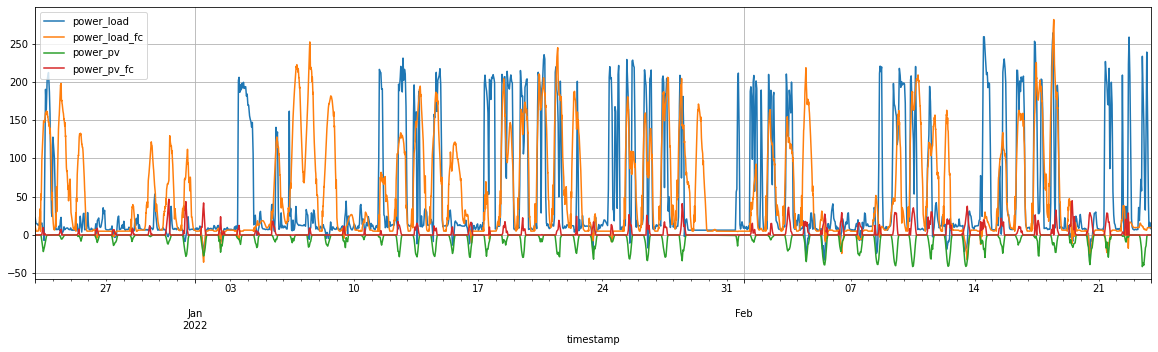

In [10]:
data=data_prepocess(winter)
data= data_context(load_generator(data))
data[['power_load','power_load_fc','power_pv','power_pv_fc']].plot()
save_data(data,'model_winter_data_fc',folder='model_data',npy=False)

<AxesSubplot:xlabel='timestamp'>

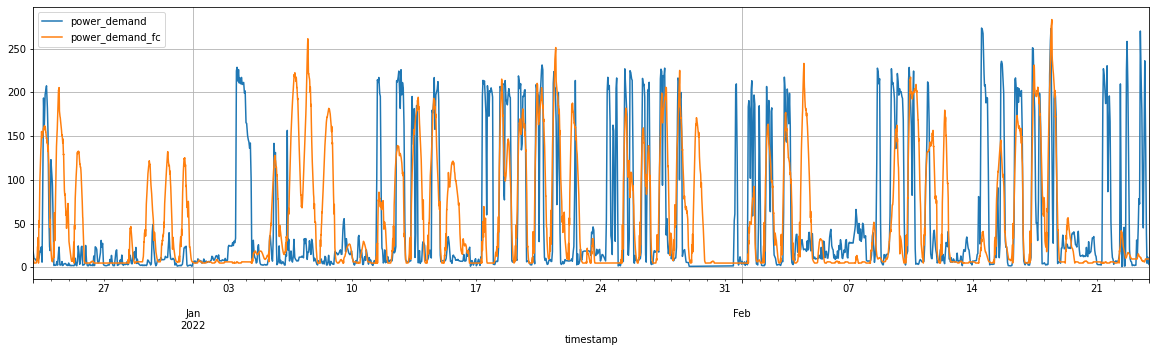

In [11]:
data[['power_demand','power_demand_fc']].plot()